In [1]:
import cv2 
import numpy as np 
from skimage.measure import label, regionprops 

# XEROX JBIG2 CASE STUDY

Xerox multifunction printers used JBIG2 compression to reduce the size of scanned documents.

JBIG2 works by:
* Finding similar-looking symbols (letters/numbers)
* Storing one copy
* Reusing it for other “similar” symbols

The problem:
The Xerox implementation mistakenly grouped different characters as “similar”.

Example:
* The number 6 was treated as the same symbol as 8
* Or 1 replaced by 7


### Consequences of problem

* Incorrect official documents
* Safety & legal risks
* Hard to detect

### How was it solved?

Xerox response:
* Acknowledged the issue (2013)
* Released firmware updates
* Disabled JBIG2 by default for scan-to-PDF

Users were advised to use:
* JBIG2 lossless mode
* PNG
* TIFF
* PDF/A

# Pattern Substitution

### Explaination

1. Binarizes the document image so symbols are foreground and background is removed.
2. Extracts connected components (each contour corresponds to one symbol).
3. Computes a simple shape descriptor for each symbol — its area (number of foreground pixels).
4. Compares symbols using area-based similarity: two symbols are considered similar if their areas differ by less than a chosen percentage (area threshold).
5. Groups symbols greedily: each symbol is either added to an existing group (if similar) or starts a new group.
6. Outputs the number of symbol groups, which represents how many distinct-looking symbols the algorithm believes exist in the document.

### Effect of changing the area threshold
* Low (e.g., 0.05) :  Many groups; even same characters may split due to noise
* Medium (e.g., 0.1) : Same characters usually grouped correctly
* High (e.g., 0.3+) : Different characters start merging into one group



### Relation with JBIG2 Case Study
In order to save space the JBIG2 algo:
* Extracted connected components (letters/symbols)
* Grouped similar-looking symbols
* Stored only one prototype per group
* Replaced all symbols in the group with that prototype

Problem: Different characters were sometimes grouped together by mistake

* In both cases: "If two symbols are similar enough, treat them as the same." This decision is controlled by a threshold and when the threshold is too loose compression improves but meaning gets corrupted.
* Area based similarity is especially dangerous as area ignores : holes inside characters, and fine structures.
* By increase area threshold, we are reproducing the Xerox failure

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [44]:
binary = cv2.imread("scanned_doc.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(binary, 127, 255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(
    binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)


In [45]:
features = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)

    if area < 30:   # noise removal
        continue

    features.append({
        "bbox": (x, y, w, h),
        "area": area
    })


In [46]:
def similar(r1, r2, area_thresh=0.0005):
    return abs(r1["area"] - r2["area"]) / r1["area"] < area_thresh


In [47]:
groups = []

for r in features:
    placed = False

    for g in groups:
        if similar(r, g[0]):
            g.append(r)
            placed = True
            break

    if not placed:
        groups.append([r])


In [48]:
print("Number of symbol groups:", len(groups))


Number of symbol groups: 9


In [49]:
# Start from original binary image (IMPORTANT FIX)
reconstructed = binary.copy()

for group in groups:
    # Choose prototype from first symbol in group
    x0, y0, w0, h0 = group[0]["bbox"]
    prototype = binary[y0:y0+h0, x0:x0+w0]

    for r in group:
        x, y, w, h = r["bbox"]

        # Resize prototype to match current bounding box
        proto_resized = cv2.resize(prototype, (w, h))

        # Replace symbol in reconstructed image
        reconstructed[y:y+h, x:x+w] = proto_resized


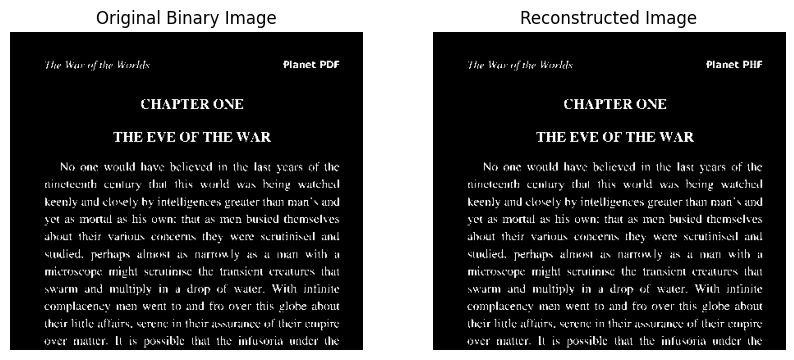

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Binary Image")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed, cmap="gray")
plt.axis("off")

plt.show()


# Human-Visible vs Machine-Relevant Differences

In [51]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
import matplotlib.pyplot as plt 

JPEG Quality 90: PSNR=41.35, SSIM=0.992


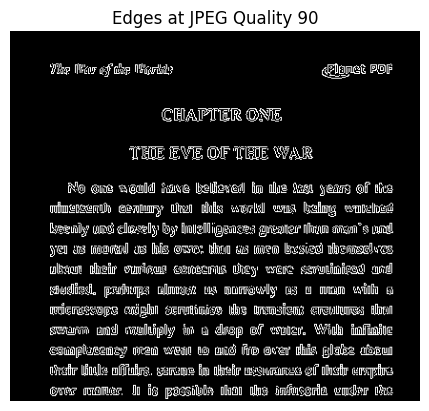

JPEG Quality 50: PSNR=30.28, SSIM=0.949


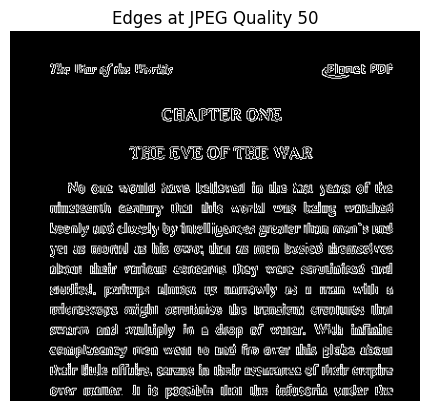

JPEG Quality 20: PSNR=25.83, SSIM=0.914


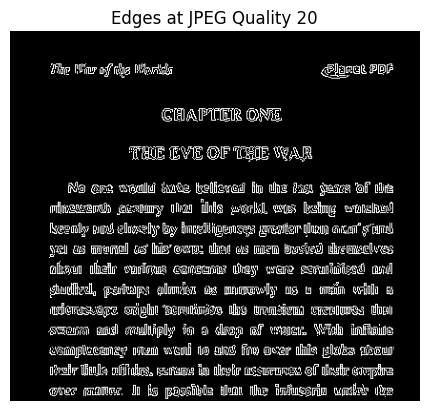

In [52]:
img = cv2.imread("scanned_doc.png", cv2.IMREAD_GRAYSCALE) 
qualities = [90, 50, 20] 
for q in qualities: 
    cv2.imwrite(f"compressed_{q}.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, q]) 
    comp = cv2.imread(f"compressed_{q}.jpg", cv2.IMREAD_GRAYSCALE) 

    psnr = peak_signal_noise_ratio(img, comp) 
    ssim = structural_similarity(img, comp) 

    edges = cv2.Canny(comp, 100, 200) 

    print(f"JPEG Quality {q}: PSNR={psnr:.2f}, SSIM={ssim:.3f}") 
    
    plt.imshow(edges, cmap='gray') 
    plt.title(f"Edges at JPEG Quality {q}") 
    plt.axis("off") 
    plt.show() 

# Silent Data Corruption Detection

JBIG2 compression operates at the symbol level and can introduce silent substitution errors where visually similar characters are replaced. While the code uses JPEG compression, it models the same failure mode by extracting connected components, computing invariant shape descriptors, and comparing structural differences between a lossless and a lossy version. This allows detection of symbol-level distortions similar to JBIG2 substitution errors

You are given two scans of the same document:
* One lossless (PNG → no information lost)
* One lossy (JPEG → compression artifacts introduced)
  
They look similar to the eye, but internally:
* Pixel values differ
* Shapes of characters may slightly deform

Goal
* Extract connected components (characters/symbols)
* Compare their structure
* Flag regions where lossy compression caused distortion

In [3]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [4]:
# Load original scanned document (grayscale)
original = cv2.imread("document.png", cv2.IMREAD_GRAYSCALE)

In [5]:
cv2.imwrite("document_lossless.png", original)

True

### Create a lossy version (JPEG compression)
* Compresses the image using JPEG
* Produces compression artifacts

In [6]:
# Encode with lossy JPEG compression
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 40]  
_, jpeg_encoded = cv2.imencode(".jpg", original, encode_param)

# Decode back to image
lossy = cv2.imdecode(jpeg_encoded, cv2.IMREAD_GRAYSCALE)

# Save lossy image
cv2.imwrite("document_lossy.png", lossy)


True

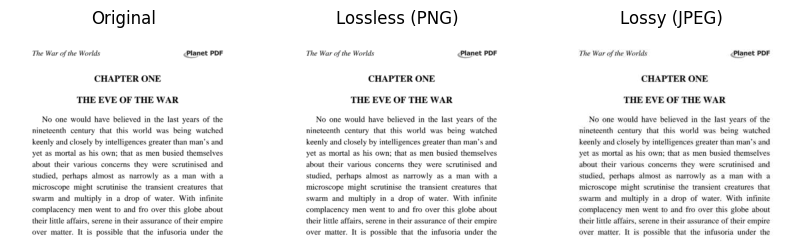

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(original, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Lossless (PNG)")
plt.imshow(original, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Lossy (JPEG)")
plt.imshow(lossy, cmap="gray")
plt.axis("off")

plt.show()


In [10]:
# Load lossless and lossy document images(Two visually similar but structurally different images)
img_lossless = cv2.imread("document_lossless.png", cv2.IMREAD_GRAYSCALE)
img_lossy = cv2.imread("document_lossy.png", cv2.IMREAD_GRAYSCALE)


### Convert images to binary (foreground vs background)

In [11]:
# Convert to binary to isolate text/symbols(Characters become clear foreground objects)
_, bin_lossless = cv2.threshold(img_lossless, 127, 255, cv2.THRESH_BINARY_INV)
_, bin_lossy = cv2.threshold(img_lossy, 127, 255, cv2.THRESH_BINARY_INV)


### Extract connected components

connectedComponentsWithStats returns:
1. Number of components
2. Label matrix
3. Statistics (bounding box, area)
4. Centroids


In [12]:
# Extract connected components from both images
cc_lossless = cv2.connectedComponentsWithStats(bin_lossless, connectivity=8)
cc_lossy = cv2.connectedComponentsWithStats(bin_lossy, connectivity=8)

# Extract labels and stats
labels_L, stats_L = cc_lossless[1], cc_lossless[2]
labels_J, stats_J = cc_lossy[1], cc_lossy[2]


### Hu Moments (shape descriptors)

Hu Moments are 7 numbers that describe the shape of an object in an image. They stay the same even if the object is moved, rotated, or resized.

Moments are just weighted sums of pixel intensities. They tell things like :
1. Where the object is
2. How spread out it is
3. How its pixels are distributed

Why are Hu moments important?
Because they allow you to say “These two shapes are the same structurally, even if one is rotated, scaled, or slightly distorted.”

That’s perfect for:
* Character recognition
* Shape comparison
* Document analysis

Hu descriptors are the processed Hu moment values used as a feature vector for comparing object shapes quantitatively. Raw Hu moments are extremely small. So we apply log

In [13]:
def hu_descriptor(binary_img, stat):
    x, y, w, h, _ = stat
    roi = binary_img[y:y+h, x:x+w] # Crop the symbol
    moments = cv2.moments(roi) # Compute image moments. Capture shape and distribution of pixels
    hu = cv2.HuMoments(moments).flatten() # Compute Hu moments
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-10) # Log scaling improves numerical stability


### Compare each symbol’s structure

In [14]:
differences = []

num_symbols = min(len(stats_L), len(stats_J)) # Ensures both images are compared safely

for i in range(1, num_symbols):  # skip background
    # Compute shape descriptors for
    hu_L = hu_descriptor(bin_lossless, stats_L[i]) 
    hu_J = hu_descriptor(bin_lossy, stats_J[i])

    # Euclidean distance between Hu vectors. Larger distance → more shape distortion
    dist = np.linalg.norm(hu_L - hu_J)
    differences.append((i, dist))


### Decide if distortion is significant

In [15]:
# Threshold for silent corruption
THRESHOLD = 0.8

suspect_symbols = [i for i, d in differences if d > THRESHOLD]

print("Flagged symbol indices:", suspect_symbols)


Flagged symbol indices: [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 157, 159, 160, 161, 163, 164, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 

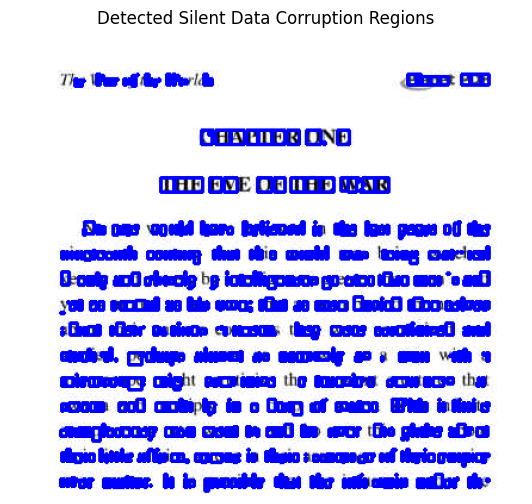

In [16]:
# Visualize corruption on lossy image
vis = cv2.cvtColor(img_lossy, cv2.COLOR_GRAY2BGR)

for i in suspect_symbols:
    x, y, w, h, _ = stats_J[i]
    cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.figure(figsize=(8,6))
plt.title("Detected Silent Data Corruption Regions")
plt.imshow(vis)
plt.axis("off")
plt.show()


# When Compression Breaks a Downstream Task

This code implements a simple rule-based OCR system using connected components, hole counting, and aspect ratio. By comparing recognition accuracy on lossless and heavily compressed documents, it shows that compression artifacts break topological features like holes, causing specific digits such as 6, 8, and 9 to fail first. This demonstrates how symbol-level distortions or substitutions can lead to silent recognition errors in document compression systems like JBIG2.

Problem Statement:

* Build a simple rule-based digit or character recognizer (not deep learning). Test it on:
  1. Original document images
  2. Heavily compressed versions
* Tasks
1. Measure recognition accuracy on both sets.
2. Identify which characters fail first and why.
3. Relate failures to compression artifacts or pattern substitution.


In [17]:
orig = cv2.imread("document_lossless.png", cv2.IMREAD_GRAYSCALE)
lossy = cv2.imread("document_lossy.png", cv2.IMREAD_GRAYSCALE)

### Binarization

In [18]:
# 3. Binarization
def binarize(img):
    _, b = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    return b

bin_orig = binarize(orig)
bin_lossy = binarize(lossy)


### Extract connected components

In [19]:
def extract_components(binary):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(binary, 8)
    comps = []
    for i in range(1, num):
        x, y, w, h, a = stats[i] # Extract bounding box of each digit
        roi = binary[y:y+h, x:x+w] # Crop it as a Region of Interest (ROI)
        comps.append((roi, (x,y,w,h)))
    return comps

comps_orig = extract_components(bin_orig)
comps_lossy = extract_components(bin_lossy)

### Counting holes and Rule based classifer

How hole counting works
1. Invert digit image
2. Background becomes foreground
3. Each enclosed region → one connected component
4. Subtract the outer background

In [20]:
# Count holes inside a digit
def count_holes(binary):
    inv = cv2.bitwise_not(binary)
    num, _, _, _ = cv2.connectedComponentsWithStats(inv, 8)
    return num - 1  # exclude background

# Rule-based digit classifier
def classify_digit(roi):
    h, w = roi.shape
    aspect = w / h
    holes = count_holes(roi)

    if holes == 2:
        return "8"
    if holes == 1:
        if aspect < 0.5:
            return "6"
        else:
            return "9"
    if holes == 0:
        if aspect < 0.4:
            return "1"
        else:
            return "0"
    return "?"

In [21]:
ground_truth = ["1","6","8","9","0","8","6","1"] # correct digit sequence in the document.

### Evaluation function

In [22]:
def evaluate(components, truth):
    preds = []
    for roi, _ in components:
        preds.append(classify_digit(roi)) # Classify each digit independently

    # Compute recognition accuracy.
    correct = sum(p == t for p, t in zip(preds, truth))
    return preds, correct / len(truth)

# Evaluate original vs compressed images
pred_orig, acc_orig = evaluate(comps_orig, ground_truth)
pred_lossy, acc_lossy = evaluate(comps_lossy, ground_truth)

print("Original Predictions:", pred_orig)
print("Original Accuracy:", acc_orig)

print("Compressed Predictions:", pred_lossy)
print("Compressed Accuracy:", acc_lossy)

Original Predictions: ['8', '?', '?', '9', '6', '6', '?', '6', '8', '?', '1', '?', '?', '?', '0', '8', '0', '0', '?', '?', '?', '8', '6', '8', '9', '0', '8', '6', '6', '0', '8', '8', '8', '6', '8', '9', '0', '6', '9', '?', '0', '9', '9', '0', '0', '0', '8', '9', '?', '8', '?', '8', '?', '?', '?', '?', '8', '8', '8', '8', '?', '8', '8', '8', '8', '8', '?', '8', '8', '?', '?', '?', '8', '9', '?', '?', '0', '9', '8', '8', '1', '8', '1', '9', '6', '0', '8', '0', '8', '1', '0', '6', '8', '?', '?', '8', '?', '?', '6', '8', '8', '?', '?', '0', '9', '8', '8', '8', '8', '8', '9', '?', '9', '9', '9', '1', '8', '?', '0', '8', '8', '8', '8', '8', '6', '9', '?', '8', '8', '?', '0', '8', '9', '8', '6', '0', '8', '8', '8', '8', '8', '0', '9', '8', '0', '8', '8', '0', '8', '8', '8', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '0', '8', '1', '?', '0', '6', '?', '?', '0', '?', '1', '6', '8', '6', '1', '6', '1', '8', '6', '8', '8', '6', '1', '6', '1', '8', '9', '8', '9', '8', '9', '6', '1', '6', '8

# Designing a “Safe Compression” Rule

The heuristic evaluates entropy to estimate information complexity, edge density to measure structural fragility, and connected-component count to detect symbol density. Text-heavy images with many edges and components are compressed losslessly, photo-like images with high entropy are compressed lossily, and ambiguous or fragile images are not compressed to avoid irreversible semantic loss.

Problem Statement
1. Design a simple heuristic to decide whether a document image should be:
2. Compressed losslessly
3. Compressed lossily
4. Not compressed at all
 
Tasks
1. Use entropy, edge density, or connected-component count as signals.
2. Implement the decision logic.

In [24]:
import cv2
import numpy as np

### Compute image entropy
* Low entropy → simple image (text, clean background)
* High entropy → complex image (photos, textures)


In [25]:
def image_entropy(gray):
    hist = cv2.calcHist([gray], [0], None, [256], [0,256]) # Histogram computation
    hist = hist / hist.sum # Normalize histogram, Converts counts → probabilities
    hist = hist[hist > 0] # Remove zero entries
    entropy = -np.sum(hist * np.log2(hist))
    return entropy

# Edge density function
* High edge density:Text, diagrams → fragile
* Low edge density: Photos → tolerant

Edges are the first thing JPEG destroys.

In [26]:
def edge_density(gray):
    edges = cv2.Canny(gray, 100, 200) # Edge detection
    return np.sum(edges > 0) / edges.size # Density calculation, normalized to image size


### Connected component count
* Counts how many separate foreground objects exist.

* High Component Count : Text document
* Low Component Count: Photograph


In [27]:
def component_count(gray):
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) # Binarization
    num, _, _, _ = cv2.connectedComponentsWithStats(binary, 8) # Component labeling
    return num - 1  # exclude background


### Compression decision logic

In [28]:
def compression_decision(gray):
    ent = image_entropy(gray)
    edges = edge_density(gray)
    comps = component_count(gray)

    # --- Heuristic rules ---
    if edges > 0.12 and comps > 100: # Many edges and many components. Lossy compression can break strokes, lead to hole loss
        return "LOSSLESS compression recommended"

    if ent > 6.5 and edges < 0.08: # high entropy -> photo like content. Low edge density -> no sharp text. Lossy compression is safe here
        return "LOSSY compression recommended"

    return "DO NOT compress"


In [29]:
img = cv2.imread("document_lossless.png", cv2.IMREAD_GRAYSCALE)

decision = compression_decision(img)
print("Compression decision:", decision)


Compression decision: DO NOT compress
